/Users/ThousandSunny/anaconda/lib/python2.7/site-packages/scipy/spatial/distance.py:1738: RuntimeWarning: invalid value encountered in true_divide
  dm /= _row_norms(XA).reshape(-1, 1)
/Users/ThousandSunny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: divide by zero encountered in log
/Users/ThousandSunny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in log
/Users/ThousandSunny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in divide
/Users/ThousandSunny/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in add


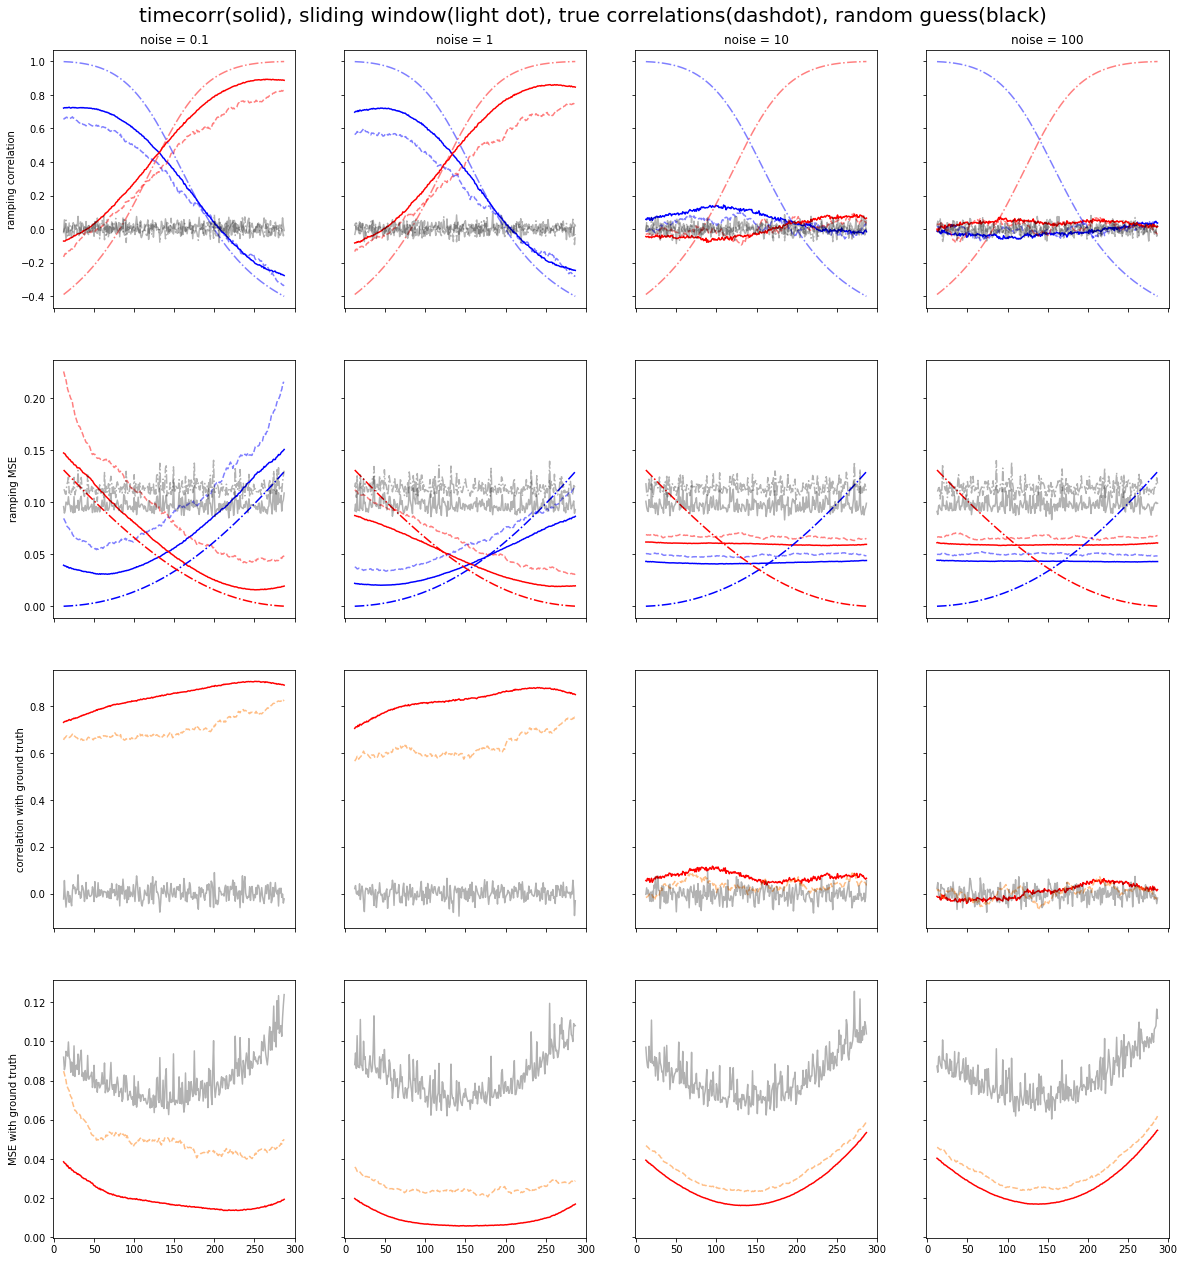

In [1]:
##### timecorr comparision with random guess, true correlations and sliding window isfc
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import isfc, sliding_window_isfc
import matplotlib.pyplot as plt
from math import log

sliding_window_length = 25
block_length = 1
covariance_num = 300
noise_level = [0.1,1,10,100]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
activation_num = 6
subject_num = 5
variance = 1000
activations = np.random.normal(0,1,[noise_num, subject_num, activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(noise_num):
        activations[i]=np.tile(activations_temp,[subject_num,1,1] )+np.random.normal(0,noise_level[i],[subject_num, activation_num, time_len])


lower_limit, upper_limit = sliding_window_length/2, time_len-sliding_window_length/2
time_range = upper_limit - lower_limit

timecorr_correlations1,timecorr_correlations2 = np.zeros([noise_num,time_len-sliding_window_length+1]),np.zeros([noise_num,time_len-sliding_window_length+1])
sliding_window_correlations1,sliding_window_correlations2 = np.zeros([noise_num,time_len-sliding_window_length+1]),np.zeros([noise_num,time_len-sliding_window_length+1])
true_correlations1,true_correlations2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)
random_correlations1,random_correlations2 = np.zeros([noise_num,time_len-sliding_window_length+1]),np.zeros([noise_num,time_len-sliding_window_length+1])

timecorr_MSE1,timecorr_MSE2 = np.zeros([noise_num,time_len-sliding_window_length+1]),np.zeros([noise_num,time_len-sliding_window_length+1])
sliding_window_MSE1,sliding_window_MSE2 = np.zeros([noise_num,time_len-sliding_window_length+1]),np.zeros([noise_num,time_len-sliding_window_length+1])
true_MSE1,true_MSE2 = np.zeros(time_len-sliding_window_length+1),np.zeros(time_len-sliding_window_length+1)
random_MSE1,random_MSE2 = np.zeros([noise_num,time_len-sliding_window_length+1]),np.zeros([noise_num,time_len-sliding_window_length+1])
color = ['b','r','k']

timecorr_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])
sliding_window_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])
true_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])
random_guess = np.zeros([noise_num, time_len,(activation_num * (activation_num-1) / 2)])
random_correlation = np.zeros([activation_num,activation_num])

timecorr_correlations_single = np.zeros([noise_num,time_range])
sliding_window_correlations_single = np.zeros([noise_num,time_range])
random_correlations_single = np.zeros([noise_num,time_range])

timecorr_MSE_single = np.zeros([noise_num,time_range])
sliding_window_MSE_single = np.zeros([noise_num,time_range])
random_MSE_single = np.zeros([noise_num,time_range])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(noise_num):
        timecorr_recovery[v] = isfc(activations[v],1000)
        sliding_window_recovery[v] = sliding_window_isfc(activations[v],sliding_window_length)
        for l in range(time_len):
            random_correlation = np.random.normal(0,1,[activation_num,activation_num])
            while not is_pos_def(random_correlation):
                random_feature_map = np.random.normal(0,1,[activation_num,activation_num])
                random_correlation = np.dot(random_feature_map,random_feature_map.T)
                random_correlation = random_correlation/np.max(abs(random_correlation))
            random_guess[v,l] = squareform(random_correlation,checks=False)
    for t in range(time_len):
        true_recovery[t] = squareform(correlations[t],checks=False)
    for timepoint in range(time_len-sliding_window_length+1):
        for v in range(noise_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint+sliding_window_length/2], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint+sliding_window_length/2], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            timecorr_MSE1[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint+sliding_window_length/2]-squareform(correlation1,checks=False)))
            timecorr_MSE2[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint+sliding_window_length/2]-squareform(correlation2,checks=False)))
            
            otcs = pearsonr(timecorr_recovery[v, timepoint+sliding_window_length/2], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint+sliding_window_length/2]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))
        
            sc1 = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            sliding_window_correlations1[v,timepoint] += 0.5 * (log(1+sc1) - log(1-sc1))
            sc2 = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            sliding_window_correlations2[v,timepoint] += 0.5 * (log(1+sc2) - log(1-sc2))

            sliding_window_MSE1[v,timepoint]+=np.mean(np.square(sliding_window_recovery[v,timepoint]-squareform(correlation1,checks=False)))
            sliding_window_MSE2[v,timepoint]+=np.mean(np.square(sliding_window_recovery[v,timepoint]-squareform(correlation2,checks=False)))

            
            rc1 = pearsonr(random_guess[v,timepoint+sliding_window_length/2], squareform(correlation1,checks=False))[0]
            random_correlations1[v,timepoint] += 0.5 * (log(1+rc1) - log(1-rc1+1e-5))
            rc2 = pearsonr(random_guess[v,timepoint+sliding_window_length/2], squareform(correlation2,checks=False))[0]
            random_correlations2[v,timepoint] += 0.5 * (log(1+rc2) - log(1-rc2+1e-5))

            random_MSE1[v,timepoint]+=np.mean(np.square(random_guess[v,timepoint+sliding_window_length/2]-squareform(correlation1,checks=False)))
            random_MSE2[v,timepoint]+=np.mean(np.square(random_guess[v,timepoint+sliding_window_length/2]-squareform(correlation2,checks=False)))

            swc = pearsonr(sliding_window_recovery[v,timepoint], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
            sliding_window_correlations_single[v,timepoint] += 0.5 * (log(1+swc) - log(1-swc))

            sliding_window_MSE_single[v,timepoint]+=np.mean(np.square(sliding_window_recovery[v,timepoint]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))        

            rc = pearsonr(random_guess[v,timepoint+sliding_window_length/2], squareform(correlations[timepoint+sliding_window_length/2],checks=False))[0]
            random_correlations_single[v,timepoint] += 0.5 * (log(1+rc) - log(1-rc))

            random_MSE_single[v,timepoint]+=np.mean(np.square(random_guess[v,timepoint+sliding_window_length/2]-squareform(correlations[timepoint+sliding_window_length/2],checks=False)))        

        tc1 = pearsonr(true_recovery[timepoint+sliding_window_length/2], squareform(correlation1,checks=False))[0]
        true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
        tc2 = pearsonr(true_recovery[timepoint+sliding_window_length/2], squareform(correlation2,checks=False))[0]
        true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))

        true_MSE1[timepoint]+=np.mean(np.square(true_recovery[timepoint+sliding_window_length/2]-squareform(correlation1,checks=False)))
        true_MSE2[timepoint]+=np.mean(np.square(true_recovery[timepoint+sliding_window_length/2]-squareform(correlation2,checks=False)))

timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

sliding_window_correlations1 /= repetitions
sliding_window_correlations1 =  (np.exp(2*sliding_window_correlations1) - 1)/(np.exp(2*sliding_window_correlations1) + 1)

sliding_window_correlations2 /= repetitions
sliding_window_correlations2 =  (np.exp(2*sliding_window_correlations2) - 1)/(np.exp(2*sliding_window_correlations2) + 1)

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

random_correlations1 /= repetitions
random_correlations1 =  (np.exp(2*random_correlations1) - 1)/(np.exp(2*random_correlations1) + 1)

random_correlations2 /= repetitions
random_correlations2 =  (np.exp(2*random_correlations2) - 1)/(np.exp(2*random_correlations2) + 1)


timecorr_MSE1/= repetitions
timecorr_MSE2/= repetitions

sliding_window_MSE1/= repetitions
sliding_window_MSE2/= repetitions

true_MSE1/= repetitions
true_MSE2/= repetitions

random_MSE1/= repetitions
random_MSE2/= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 
sliding_window_correlations_single /= repetitions
sliding_window_correlations_single =(np.exp(2*sliding_window_correlations_single) - 1)/(np.exp(2*sliding_window_correlations_single) + 1) 
random_correlations_single /= repetitions
random_correlations_single =(np.exp(2*random_correlations_single) - 1)/(np.exp(2*random_correlations_single) + 1) 

timecorr_MSE_single /= repetitions
sliding_window_MSE_single /= repetitions
random_MSE_single /= repetitions


f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(20,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("timecorr(solid), sliding window(light dot), true correlations(dashdot), random guess(black)",fontsize=20)
a1[0].set_title("noise = 0.1")
a1[1].set_title("noise = 1")
a1[2].set_title("noise = 10")
a1[3].set_title("noise = 100")
a1[0].set_ylabel("ramping correlation")
a2[0].set_ylabel("ramping MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(noise_num): 
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0, label = "timecorr recovery wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0,label = "timecorr recovery wrt component B")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1[v],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations2[v],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),true_correlations1,c=color[0],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),true_correlations2,c=color[1],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component B")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),random_correlations1[v],c=color[2],linestyle='-',alpha=0.3,label = "random guess wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),random_correlations2[v],c=color[2],linestyle='-.',alpha=0.3,label = "random guess wrt component B")
    if v==var_num-1:
        a1[v].legend(bbox_to_anchor=(2, 1), loc=1)
        
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE1[v],c=color[0],linestyle='-',alpha=1.0, label = "timecorr recovery wrt component A")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE2[v],c=color[1],linestyle='-',alpha=1.0,label = "timecorr recovery wrt component B")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE1[v],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE2[v],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),true_MSE1,c=color[0],linestyle='-.',alpha=1,label = "temporal ground truth wrt component A")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),true_MSE2,c=color[1],linestyle='-.',alpha=1,label = "temporal ground truth wrt component B")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),random_MSE1[v],c=color[2],linestyle='-',alpha=0.3,label = "random guess wrt component A")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),random_MSE2[v],c=color[2],linestyle='-.',alpha=0.3,label = "random guess wrt component B")
    if v==var_num-1:
        a2[v].legend(bbox_to_anchor=(2, 1), loc=1)
        
    a3[v].plot(range(lower_limit,upper_limit),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a3[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single[v],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a3[v].plot(range(lower_limit,upper_limit),random_correlations_single[v],c='k',alpha=0.3,linestyle='-', label = "random guess wrt temporal ground truth")
    if v==var_num-1:
        a3[v].legend(bbox_to_anchor=(2, 1), loc=1)
    
    a4[v].plot(range(lower_limit,upper_limit),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a4[v].plot(range(lower_limit,upper_limit),sliding_window_MSE_single[v],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a4[v].plot(range(lower_limit,upper_limit),random_MSE_single[v],c='k',alpha=0.3,linestyle='-', label = "random guess wrt temporal ground truth")
    if v==var_num-1:
        a4[v].legend(bbox_to_anchor=(2, 1), loc=1)
    
plt.show()

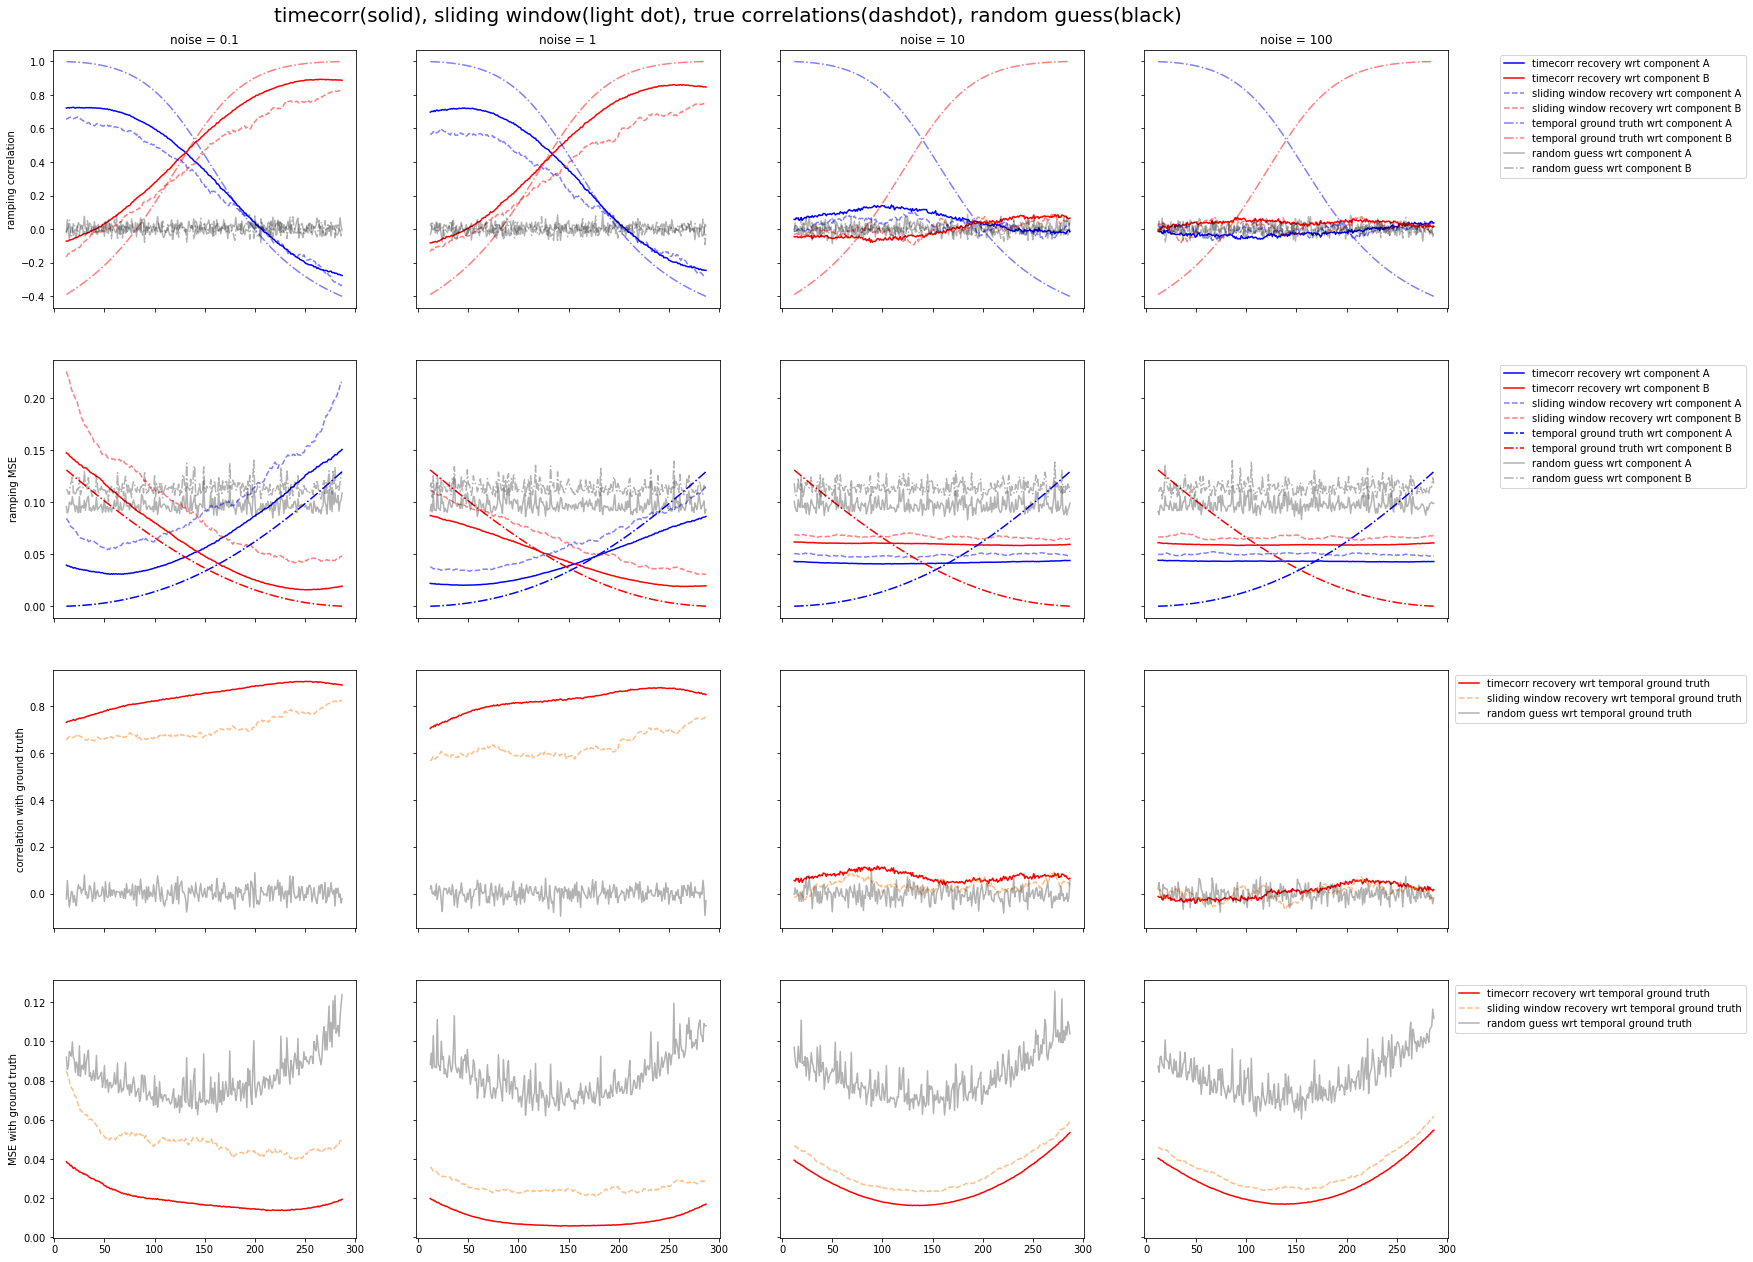

In [6]:
f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(25,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("timecorr(solid), sliding window(light dot), true correlations(dashdot), random guess(black)",fontsize=20)
a1[0].set_title("noise = 0.1")
a1[1].set_title("noise = 1")
a1[2].set_title("noise = 10")
a1[3].set_title("noise = 100")
a1[0].set_ylabel("ramping correlation")
a2[0].set_ylabel("ramping MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(noise_num): 
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0, label = "timecorr recovery wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0,label = "timecorr recovery wrt component B")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations1[v],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_correlations2[v],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),true_correlations1,c=color[0],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),true_correlations2,c=color[1],linestyle='-.',alpha=0.5,label = "temporal ground truth wrt component B")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),random_correlations1[v],c=color[2],linestyle='-',alpha=0.3,label = "random guess wrt component A")
    a1[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),random_correlations2[v],c=color[2],linestyle='-.',alpha=0.3,label = "random guess wrt component B")
    if v==noise_num-1:
        a1[v].legend(bbox_to_anchor=(2, 1), loc=1)
        
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE1[v],c=color[0],linestyle='-',alpha=1.0, label = "timecorr recovery wrt component A")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),timecorr_MSE2[v],c=color[1],linestyle='-',alpha=1.0,label = "timecorr recovery wrt component B")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE1[v],c=color[0],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component A")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),sliding_window_MSE2[v],c=color[1],linestyle='--',alpha=0.5,label = "sliding window recovery wrt component B")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),true_MSE1,c=color[0],linestyle='-.',alpha=1,label = "temporal ground truth wrt component A")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),true_MSE2,c=color[1],linestyle='-.',alpha=1,label = "temporal ground truth wrt component B")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),random_MSE1[v],c=color[2],linestyle='-',alpha=0.3,label = "random guess wrt component A")
    a2[v].plot(range(sliding_window_length/2,time_len-sliding_window_length/2),random_MSE2[v],c=color[2],linestyle='-.',alpha=0.3,label = "random guess wrt component B")
    if v==noise_num-1:
        a2[v].legend(bbox_to_anchor=(2, 1), loc=1)
        
    a3[v].plot(range(lower_limit,upper_limit),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a3[v].plot(range(lower_limit,upper_limit),sliding_window_correlations_single[v],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a3[v].plot(range(lower_limit,upper_limit),random_correlations_single[v],c='k',alpha=0.3,linestyle='-', label = "random guess wrt temporal ground truth")
    if v==noise_num-1:
        a3[v].legend(bbox_to_anchor=(2, 1), loc=1)
    
    a4[v].plot(range(lower_limit,upper_limit),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-', label = "timecorr recovery wrt temporal ground truth")
    a4[v].plot(range(lower_limit,upper_limit),sliding_window_MSE_single[v],c='C1',alpha=0.5,linestyle='--', label = "sliding window recovery wrt temporal ground truth")
    a4[v].plot(range(lower_limit,upper_limit),random_MSE_single[v],c='k',alpha=0.3,linestyle='-', label = "random guess wrt temporal ground truth")
    if v==noise_num-1:
        a4[v].legend(bbox_to_anchor=(2, 1), loc=1)
    
plt.show()

In [ ]:
##### timecorr comparision with no noise and true correlations
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import isfc, wcorr
import matplotlib.pyplot as plt
from math import log

sliding_window_length = 51
block_length = 1
covariance_num = 1000
noise_level = [0,0.1,1,5,10]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
activation_num = 6
subject_num = 5
variance = 1000
activations = np.random.normal(0,1,[noise_num, subject_num, activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len/2):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(time_len/2):
        correlations[time_len/2+i] =  correlations[time_len/2-i-1]
        activations_temp[:,time_len/2+i] = np.dot(cholesky(correlations[time_len/2+i]),activations_temp[:,time_len/2+i])
    for i in range(noise_num):
        activations[i]=np.tile(activations_temp,[subject_num,1,1] )+np.random.normal(0,noise_level[i],[subject_num, activation_num, time_len])


timecorr_correlations1,timecorr_correlations2 = np.zeros([noise_num,time_len]),np.zeros([noise_num,time_len])

timecorr_MSE1,timecorr_MSE2 = np.zeros([noise_num,time_len]),np.zeros([noise_num,time_len])

timecorr_correlations_single = np.zeros([noise_num,time_range])

timecorr_MSE_single = np.zeros([noise_num,time_range])
color = ['b','r']

true_correlations1,true_correlations2 = np.zeros(time_len),np.zeros(time_len)
true_MSE1,true_MSE2 = np.zeros(time_len),np.zeros(time_len)

timecorr_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(noise_num):
        timecorr_recovery[v] = isfc(activations[v],1000)
    for timepoint in range(time_len):
        tc1 = pearsonr(squareform(correlations[timepoint],checks=False), squareform(correlation1,checks=False))[0]
        true_correlations1[timepoint] += 0.5 * (log(1+tc1) - log(1-tc1+1e-5))
        tc2 = pearsonr(squareform(correlations[timepoint],checks=False), squareform(correlation2,checks=False))[0]
        true_correlations2[timepoint] += 0.5 * (log(1+tc2) - log(1-tc2+1e-5))
        true_MSE1[timepoint]+=np.mean(np.square(correlations[timepoint]-correlation1))
        true_MSE2[timepoint]+=np.mean(np.square(correlations[timepoint]-correlation2))
        
        for v in range(noise_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            sqr_mean = np.mean(np.square(timecorr_recovery[v,timepoint]))
            timecorr_MSE1[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint]-squareform(correlation1,checks=False)))
            timecorr_MSE2[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint]-squareform(correlation2,checks=False)))
            
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[timepoint],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint]-squareform(correlations[timepoint],checks=False)))
            
            
        
timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

timecorr_MSE1/= repetitions
timecorr_MSE2/= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

timecorr_MSE_single /= repetitions

true_correlations1 /= repetitions
true_correlations1 =  (np.exp(2*true_correlations1) - 1)/(np.exp(2*true_correlations1) + 1)

true_correlations2 /= repetitions
true_correlations2 =  (np.exp(2*true_correlations2) - 1)/(np.exp(2*true_correlations2) + 1)

true_MSE1/= repetitions
true_MSE2/= repetitions

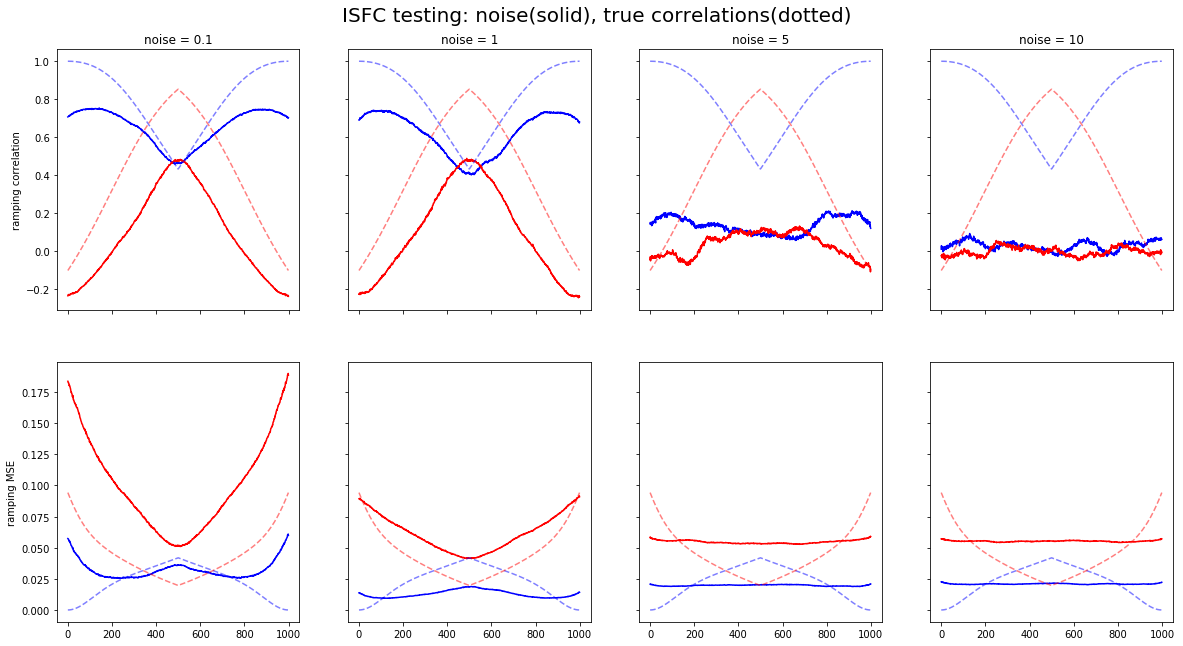

In [19]:
f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(2,4, sharex=True, sharey='row', figsize=(20,10))
a1,a2= [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]
plt.subplots_adjust(top=0.92)
plt.suptitle("ISFC testing: noise(solid), true correlations(dotted)",fontsize=20)
a1[0].set_title("noise = 0.1")
a1[1].set_title("noise = 1")
a1[2].set_title("noise = 5")
a1[3].set_title("noise = 10")
a1[0].set_ylabel("ramping correlation")
a2[0].set_ylabel("ramping MSE")
for v in range(1,noise_num): 
    a1[v-1].plot(range(time_len),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0)
    a1[v-1].plot(range(time_len),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0)

    a2[v-1].plot(range(time_len),timecorr_MSE1[v],c=color[0],linestyle='-',alpha=1.0)
    a2[v-1].plot(range(time_len),timecorr_MSE2[v],c=color[1],linestyle='-',alpha=1.0)

    a1[v-1].plot(range(time_len),true_correlations1,c=color[0],linestyle='--',alpha=0.5)
    a1[v-1].plot(range(time_len),true_correlations2,c=color[1],linestyle='--',alpha=0.5)

    a2[v-1].plot(range(time_len),true_MSE1,c=color[0],linestyle='--',alpha=0.5)
    a2[v-1].plot(range(time_len),true_MSE2,c=color[1],linestyle='--',alpha=0.5)
    
plt.show()

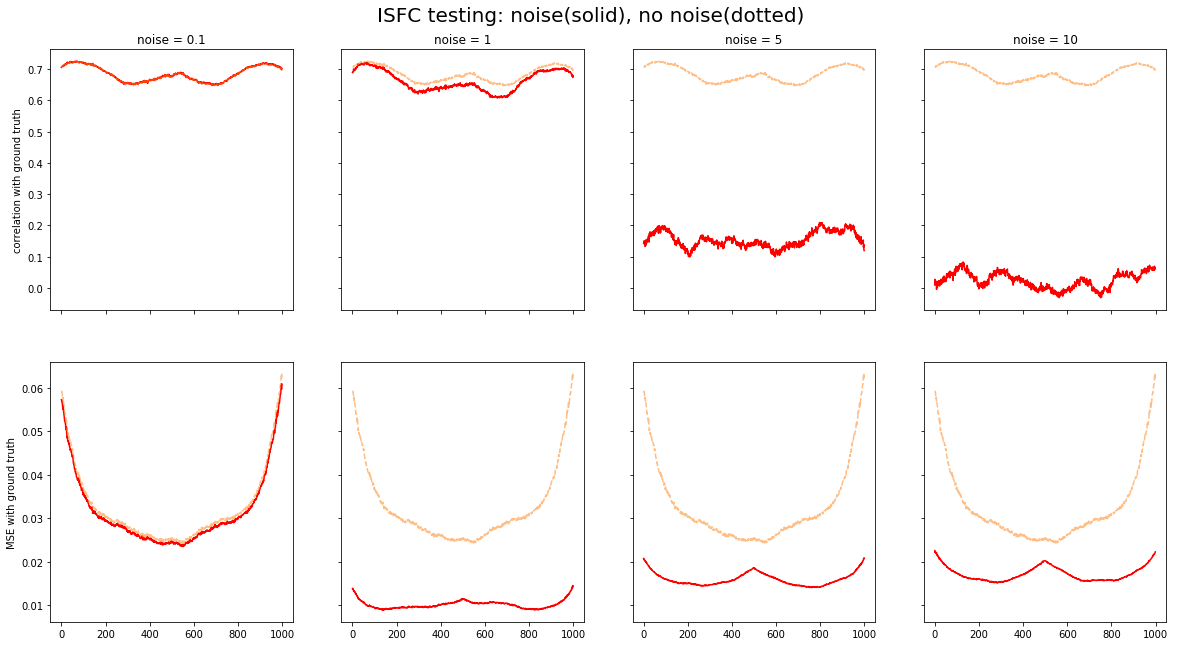

In [20]:
f, ((ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(2,4, sharex=True, sharey='row', figsize=(20,10))
a3,a4 = [ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.92)
plt.suptitle("ISFC testing: noise(solid), no noise(dotted)",fontsize=20)
a3[0].set_title("noise = 0.1")
a3[1].set_title("noise = 1")
a3[2].set_title("noise = 5")
a3[3].set_title("noise = 10")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(1,noise_num):
    a3[v-1].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a4[v-1].plot(range(time_len),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-')

    a3[v-1].plot(range(time_len),timecorr_correlations_single[0],c='C1',linestyle='--',alpha=0.5)
    a4[v-1].plot(range(time_len),timecorr_MSE_single[0],c='C1',linestyle='--',alpha=0.5)
    
plt.show()

In [1]:
###### timecorr comparison with no noise
%%time
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import isfc, wcorr
import matplotlib.pyplot as plt
from math import log

sliding_window_length = 51
block_length = 1
covariance_num = 1000
noise_level = [0,0.01,0.1,0.5,1]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
activation_num = 6
subject_num = 5
variance = 1000
activations = np.random.normal(0,1,[noise_num, subject_num, activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (1000-i)*correlation1/float(time_len)+i*correlation2/float(time_len)
        correlations[i] = cov_temp/np.max(abs(cov_temp))
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(noise_num):
        activations[i]=np.tile(activations_temp,[subject_num,1,1] )+np.random.normal(0,noise_level[i],[subject_num, activation_num, time_len])


timecorr_correlations1,timecorr_correlations2 = np.zeros([noise_num,time_len]),np.zeros([noise_num,time_len])

timecorr_MSE1,timecorr_MSE2 = np.zeros([noise_num,time_len]),np.zeros([noise_num,time_len])

timecorr_correlations_single = np.zeros([noise_num,time_range])

timecorr_MSE_single = np.zeros([noise_num,time_range])
color = ['b','r']

timecorr_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(noise_num):
        timecorr_recovery[v] = isfc(activations[v],1000)
    for timepoint in range(time_len):
        for v in range(noise_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            sqr_mean = np.mean(np.square(timecorr_recovery[v,timepoint]))
            timecorr_MSE1[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint]-squareform(correlation1,checks=False)))/sqr_mean
            timecorr_MSE2[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint]-squareform(correlation2,checks=False)))/sqr_mean
            
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[timepoint],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint]-squareform(correlations[timepoint],checks=False)))/sqr_mean
        
        
timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

timecorr_MSE1/= repetitions
timecorr_MSE2/= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

timecorr_MSE_single /= repetitions

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: divide by zero encountered in log
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in log
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:64: RuntimeWarning: invalid value encountered in divide


KeyboardInterrupt: 

In [ ]:
f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(20,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("ISFC testing: noise(solid), no noise(dotted)",fontsize=20)
a1[0].set_title("noise = 0.01")
a1[1].set_title("noise = 0.1")
a1[2].set_title("noise = 0.5")
a1[3].set_title("noise = 1")
a1[0].set_ylabel("ramping correlation")
a2[0].set_ylabel("ramping MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(1,noise_num): 
    a1[v-1].plot(range(time_len),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0)
    a1[v-1].plot(range(time_len),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0)

    a2[v-1].plot(range(time_len),timecorr_MSE1[v],c=color[0],linestyle='-',alpha=1.0)
    a2[v-1].plot(range(time_len),timecorr_MSE2[v],c=color[1],linestyle='-',alpha=1.0)

    a3[v-1].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a4[v-1].plot(range(time_len),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-')
    
    a1[v-1].plot(range(time_len),timecorr_correlations1[0],c=color[0],linestyle='--',alpha=0.5)
    a1[v-1].plot(range(time_len),timecorr_correlations2[0],c=color[1],linestyle='--',alpha=0.5)

    a2[v-1].plot(range(time_len),timecorr_MSE1[0],c=color[0],linestyle='--',alpha=0.5)
    a2[v-1].plot(range(time_len),timecorr_MSE2[0],c=color[1],linestyle='--',alpha=0.5)

    a3[v-1].plot(range(time_len),timecorr_correlations_single[0],c='C1',linestyle='--',alpha=0.5)
    a4[v-1].plot(range(time_len),timecorr_MSE_single[0],c='C1',linestyle='--',alpha=0.5)
    
plt.show()